In [61]:
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
import numpy as np
from kf_book.book_plots import figsize, set_figsize
import kf_book.book_plots as book_plots
import matplotlib.pyplot as plt
from filterpy.discrete_bayes import normalize
from filterpy.discrete_bayes import update
from filterpy.discrete_bayes import predict
load_style()

# Bayesian Filters

- Discrete Bayesian Filter
- Kalman Filter and applications
- Extended Kalman Filter (EKF)
- Unscented Kalman Filter (UKF)
- Particle Filter
- Adaptive Filtering

### Localization Example

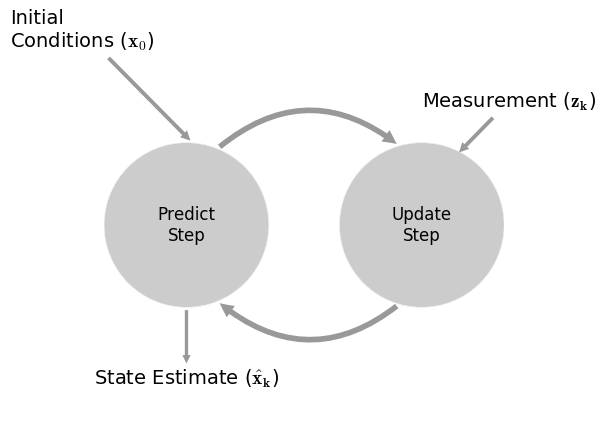

In [2]:
book_plots.predict_update_chart()

**Initialization**

    1. Initialize our belief in the state
    
**Predict**

    1. Based on the system behavior, predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Determine whether the measurement matches each state
    4. Update state belief if it matches the measurement

In [62]:
def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

def discrete_bayes_sim(pos, kernel, zs, z_prob_correct, sleep=0.25):
    #%matplotlib notebook
    N = len(hallway)
    #fig = plt.figure()
    for i, z in enumerate(zs):
        #plt.cla()
        prior = predict(pos, 1, kernel)
        book_plots.bar_plot(hallway, c='k')
        book_plots.bar_plot(prior, ylim=(0,1.0), c='#ff8015')
        plt.axvline(i % N, lw=5)
        plt.show()
        #fig.canvas.draw()
        #time.sleep(sleep)

        #plt.cla()
        likelihood = lh_hallway(hallway, z=z, z_prob=z_prob_correct)
        pos = update(likelihood, prior)
        book_plots.bar_plot(hallway, c='k')
        book_plots.bar_plot(pos, ylim=(0,1.0))
        plt.axvline(i % 10, lw=5)
        #fig.canvas.draw()
        #time.sleep(sleep)
        plt.show()
    %matplotlib inline
    set_figsize(y=2)
    print('Final posterior:', pos)


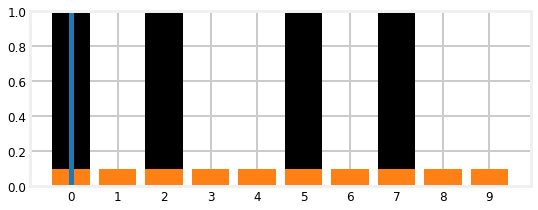

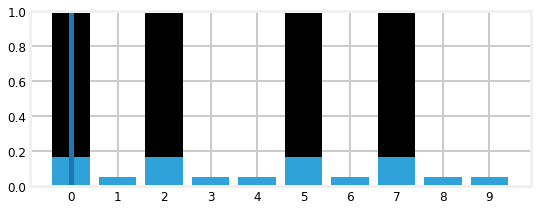

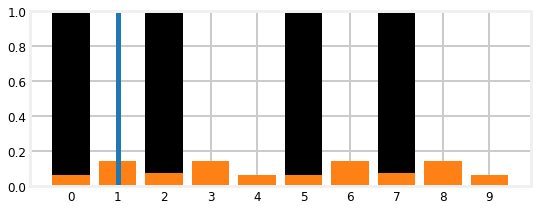

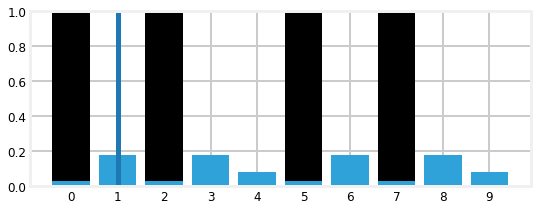

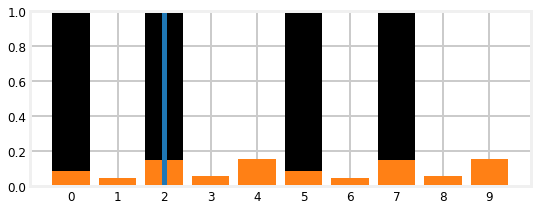

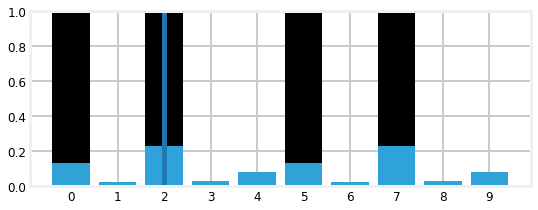

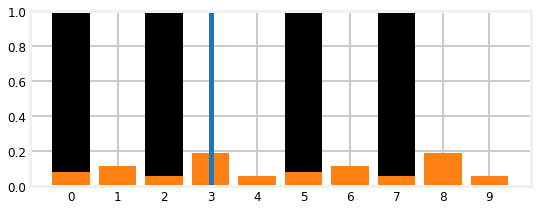

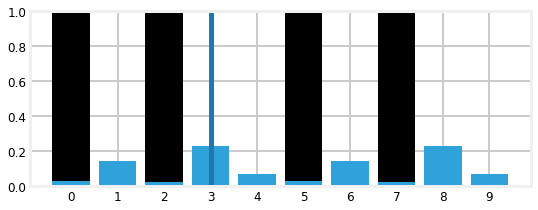

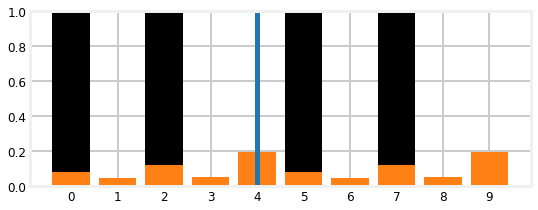

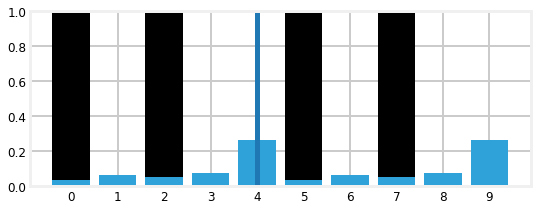

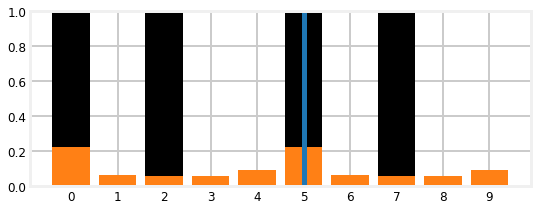

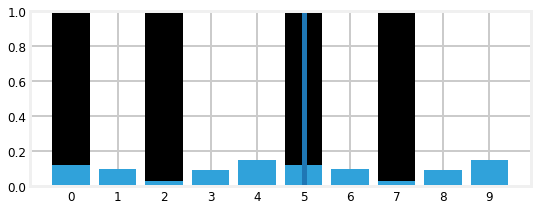

Final posterior: [0.121 0.102 0.033 0.094 0.151 0.121 0.102 0.033 0.094 0.151]


In [63]:
measurements = [1, 0, 1, 0, 0, 0]
discrete_bayes_sim(prior, kernel, measurements, z_prob);

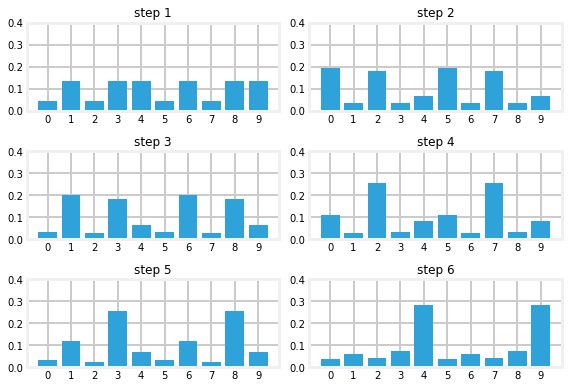

In [64]:
with figsize(y=5.5):
    measurements = [0, 1, 0, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(3, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title='step {}'.format(i+1))
    plt.tight_layout()

### Product of Gaussians

You can find this result by multiplying the equation for two Gaussians together and combining terms. The algebra gets messy. I will derive it using Bayes theorem. We can state the problem as: let the prior be $N(\bar\mu, \bar\sigma^2)$, and measurement be $z \propto N(z, \sigma_z^2)$. What is the posterior  x given the measurement z?

Write the posterior as $P(x \mid z)$. Now we can use Bayes Theorem to state

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$

$P(z)$ is a normalizing constant, so we can create a proportinality

$$P(x \mid z) \propto P(z|x)P(x)$$

Now we subtitute in the equations for the Gaussians, which are

$$P(z \mid x) = \frac{1}{\sqrt{2\pi\sigma_z^2}}\exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]$$

$$P(x) = \frac{1}{\sqrt{2\pi\bar\sigma^2}}\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]$$

We can drop the leading terms, as they are constants, giving us

$$\begin{aligned}
P(x \mid z) &\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]\\
&\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z-x)^2-\sigma_z^2(x-\bar\mu)^2]\Big]
\end{aligned}$$

Now we multiply out the squared terms and group in terms of the posterior $x$.

$$\begin{aligned}
P(x \mid z) &\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z^2 -2xz + x^2) + \sigma_z^2(x^2 - 2x\bar\mu+\bar\mu^2)]\Big ] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z) + (\bar\sigma^2z^2+\sigma_z^2\bar\mu^2)]\Big ]
\end{aligned}$$

The last parentheses do not contain the posterior $x$, so it can be treated as a constant and discarded.

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z)}{\sigma_z^2\bar\sigma^2}\Big ]
$$

Divide numerator and denominator by $\bar\sigma^2+\sigma_z^2$ to get

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2-2x(\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

Proportionality allows us create or delete constants at will, so we can factor this into

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{(x-\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})^2}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

A Gaussian is

$$N(\mu,\, \sigma^2) \propto \exp\Big [-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2}\Big ]$$

So we can see that $P(x \mid z)$ has a mean of

$$\mu_\mathtt{posterior} = \frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2}$$

and a variance of
$$
\sigma_\mathtt{posterior} = \frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}
$$

I've dropped the constants, and so the result is not a normal, but proportional to one. Bayes theorem normalizes with the $P(z)$ divisor, ensuring that the result is normal. We normalize in the update step of our filters, ensuring the filter estimate is Gaussian.

$$\mathcal N_1 = \| \mathcal N_2\cdot \mathcal N_3\|$$

### Sum of Gaussians

The sum of two Gaussians is given by

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

There are several proofs for this. I will use convolution since we used convolution in the previous chapter for the histograms of probabilities. 

To find the density function of the sum of two Gaussian random variables we sum the density functions of each. They are nonlinear, continuous functions, so we need to compute the sum with an integral. If the random variables $p$ and $z$ (e.g. prior and measurement) are independent we can compute this with

$p(x) = \int\limits_{-\infty}^\infty f_p(x-z)f_z(z)\, dx$

This is the equation for a convolution. Now we just do some math:


$p(x) = \int\limits_{-\infty}^\infty f_2(x-x_1)f_1(x_1)\, dx$

$=  \int\limits_{-\infty}^\infty 
\frac{1}{\sqrt{2\pi}\sigma_z}\exp\left[-\frac{(x - z - \mu_z)^2}{2\sigma^2_z}\right]
\frac{1}{\sqrt{2\pi}\sigma_p}\exp\left[-\frac{(x - \mu_p)^2}{2\sigma^2_p}\right] \, dx$

$=  \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

$= \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right] \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

The expression inside the integral is a normal distribution. The sum of a normal distribution is one, hence the integral is one. This gives us

$$p(x) = \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]$$

This is in the form of a normal, where

$$\begin{gathered}\mu_x = \mu_p + \mu_z \\
\sigma_x^2 = \sigma_z^2+\sigma_p^2\, \square\end{gathered}$$

## Full Description of the Algorithm

<img src="./figs/residual_chart.png">

You will be hard pressed to find a Bayesian filter algorithm that does not fit into this form. Some filters will not include some aspects, such as error in the prediction, and others will have very complicated methods of computation, but this is what they all do. 

The equations for the univariate Kalman filter are:

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

<img src='animations/05_volt_animate.gif'>

The top plot in the animation draws a green line for the predicted next voltage, then a red '+' for the actual measurement, draws a light red line to show the residual, and then draws a blue line to the filter's output. You can see that when the filter starts the corrections made are quite large, but after only a few updates the filter only adjusts its output by a small amount even when the measurement is far from it. 

The lower plot shows the Gaussian belief as the filter innovates. When the filter starts the Gaussian curve is centered over 25, our initial guess for the voltage, and is very wide and short due to our initial uncertainty. But as the filter innovates, the Gaussian quickly moves to about 16.0 and becomes taller, reflecting the growing confidence that the filter has in it's estimate for the voltage. You will also note that the Gaussian's height bounces up and down a little bit. If you watch closely you will see that the Gaussian becomes a bit shorter and more spread out during the prediction step, and becomes taller and narrower as the filter incorporates another measurement.

### Multivariate

The combination of measurements 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. The capital sigma ($\Sigma$) indicates that these are matrices, not scalars. Specifically, they are covariance matrices:

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$


They are generated by plugging the multivariate Gaussians for the prior and the estimate into Bayes Theorem. 

You will not need to remember these equations as they are computed by Kalman filter equations that will be presented shortly.

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* a reciprocal since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do as division for matrices is not defined, but it does help us compare the equations.

$$\begin{aligned}
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form the relationship between the univariate and multivariate equations is clear.

Now let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with two radar systems. I will ignore altitude so I can use two dimensional plots. Radar provides the range and bearing to a target.

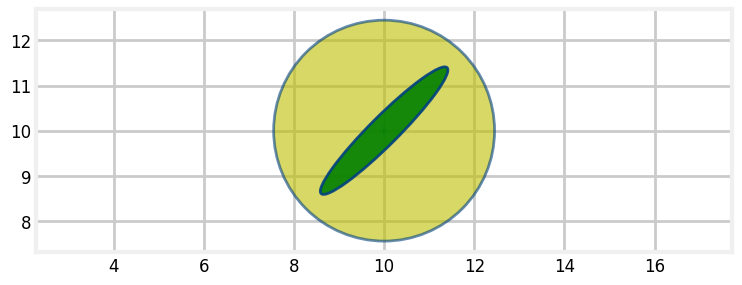

In [8]:
from filterpy.stats import plot_covariance_ellipse
P0 = [[6, 0], [0, 6]]
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

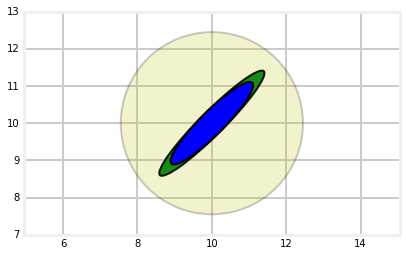

In [26]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

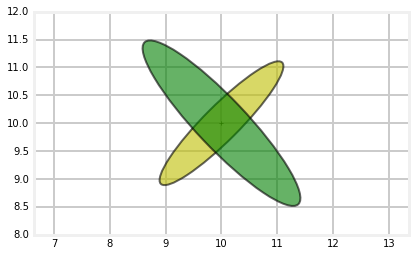

In [27]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

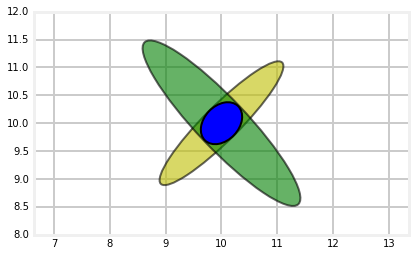

In [28]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

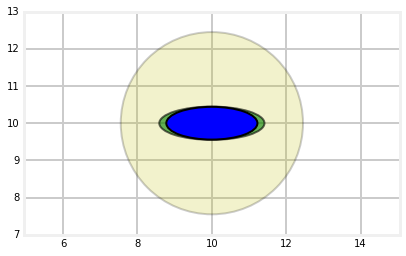

In [29]:
P1 = [[2, 0], [0, .2]]
P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

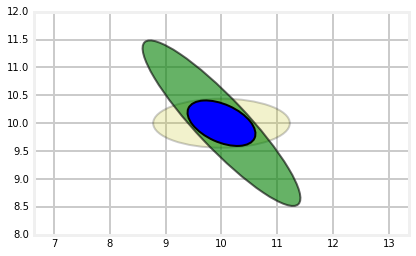

In [30]:
P3 = [[2, -1.9], [-1.9, 2.2]]
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

### Summary

If we set the dimension of $\mathbf x$ to one these equations revert back to the equations for the univariate filter. This is not "like" the univariate filter - it is a multidimensional implementation of it.

<u>Predict</u>

$\begin{array}{|l|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form} & \text{Multivariate Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx & \mathbf{\bar x} = \mathbf{F x} + \mathbf{B u} \\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q & \mathbf{\bar P} = \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form} & \text{Multivariate Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x &  \textbf{y} = \mathbf z - \mathbf{H \bar x}\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R} & \mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
 & \mu = \bar \mu + Ky & x = \bar x + Ky & \textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P & \mathbf x =\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
 &&& \mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}\\
\hline
\end{array}$


### Design the Process Model

We assume a Newtonian, kinematic system for the aircraft. We've used this model in previous chapters, so by inspection you may recognize that we want

$$\mathbf F = \left[\begin{array}{cc} 1 & \Delta t \\
0 & 1\\
\end{array}\right]$$

However, let's practice finding these matrices. We model systems with a set of differential equations. We need an equation in the form 

$$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{w}$$
where $\mathbf{w}$ is the system noise. 

The variables $x$ and $y$ are independent so we can compute them separately. The differential equations for motion in one dimension are:

$$\begin{aligned}v &= \dot x \\
a &= \ddot{x} = 0\end{aligned}$$

Now we put the differential equations into state-space form. If this was a second or greater order differential system we would have to first reduce them to an equivalent set of first degree equations. The equations are first order, so we put them in state space matrix form as

$$\begin{aligned}\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} &= \begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ 
\dot x\end{bmatrix} \\ \dot{\mathbf x} &= \mathbf{Ax}\end{aligned}$$
where $\mathbf A=\begin{bmatrix}0&1\\0&0\end{bmatrix}$. 

Recall that $\mathbf A$ is the *system dynamics matrix*. It describes a set of linear differential equations. From it we must compute the state transition matrix $\mathbf F$. $\mathbf F$ describes a discrete set of linear equations which compute $\mathbf x$ for a discrete time step $\Delta t$.

A common way to compute $\mathbf F$ is to use the power series expansion of the matrix exponential:

$$\mathbf F(\Delta t) = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A \Delta t)^3}{3!} + ... $$


$\mathbf A^2 = \begin{bmatrix}0&0\\0&0\end{bmatrix}$, so all higher powers of $\mathbf A$ are also $\mathbf{0}$. Thus the power series expansion is:

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf At + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
\mathbf F &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

This is the same result used by the kinematic equations! This exercise was unnecessary other than to illustrate finding the state transition matrix from linear differential equations. We will conclude the chapter with an example that will require the use of this technique.

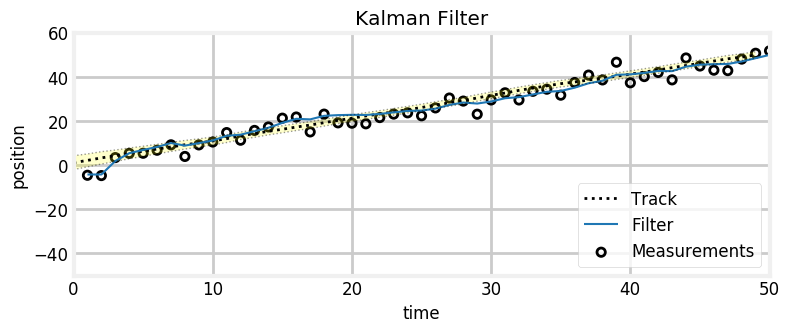

In [6]:
from numpy import dot
from scipy.linalg import inv
from kf_book.mkf_internal import plot_track
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import math

dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)


count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False, dt=dt)

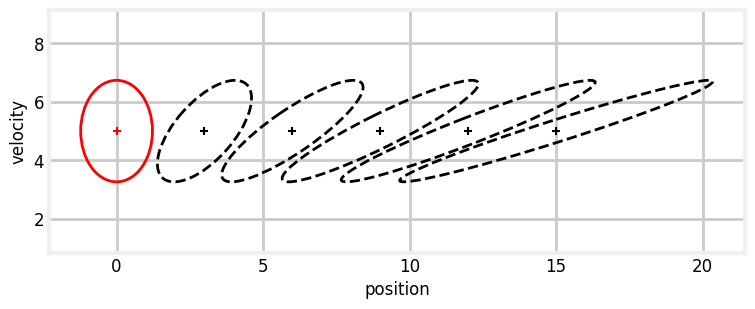

In [9]:
dt = 0.6
x = np.array([0., 5.])
F = np.array([[1., dt], [0, 1.]])
P = np.array([[1.5, 0], [0, 3.]])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = np.dot(F, x)
    P = np.dot(F, P).dot(F.T)
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
book_plots.set_labels(x='position', y='velocity')

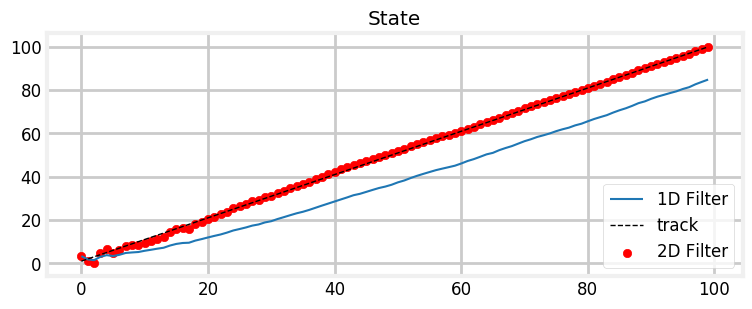

In [10]:
from math import sqrt
from numpy.random import randn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.x = np.array([[x0]])
    f.P *= P
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label='1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c='r', label='2D Filter')
    plt.plot(xs, ls='--', color='k', lw=1, label='track')
    plt.title('State')
    plt.legend(loc=4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u=0):
    # storage for filter output
    xs, xs1, xs2 = [], [], []

    # 1d KalmanFilter
    f1D = univariate_filter(x0, P, R, Q)

    #2D Kalman filter
    f2D = pos_vel_filter(x=(x0, vel), P=P, R=R, Q=0)
    
    pos = 0 # true position
    for i in range(100):
        pos += vel
        xs.append(pos)

        # control input u - discussed below
        f1D.predict(u=u)
        f2D.predict()
        
        z = pos + randn()*sqrt(R) # measurement
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)

compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1.) 

### Non-Linear

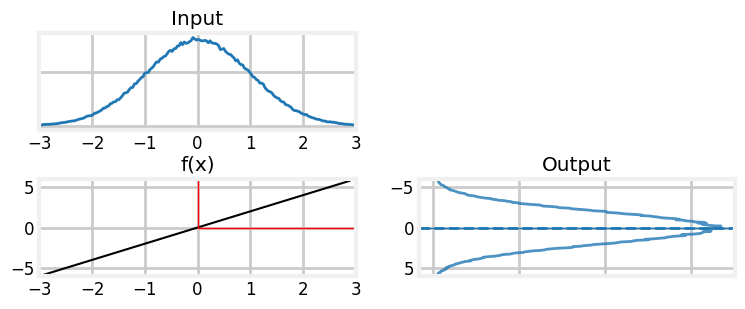

In [52]:
from kf_book.book_plots import set_figsize, figsize
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal

gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def g1(x):
    return 2*x

plot_nonlinear_func(data, g1, gaussian)

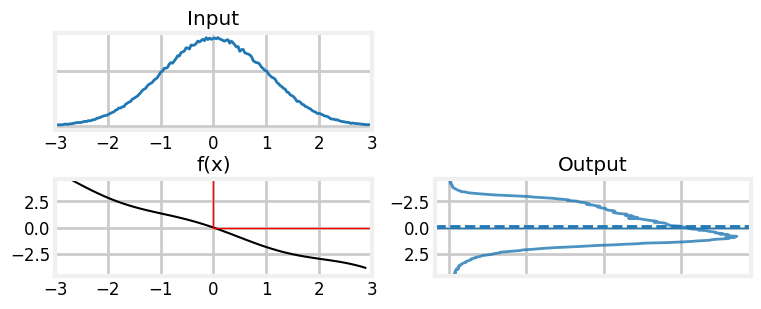

In [15]:
def g2(x):
    return (np.cos(3*(x/2 + 0.7))) * np.sin(0.3*x) - 1.6*x

plot_nonlinear_func(data, g2, gaussian)

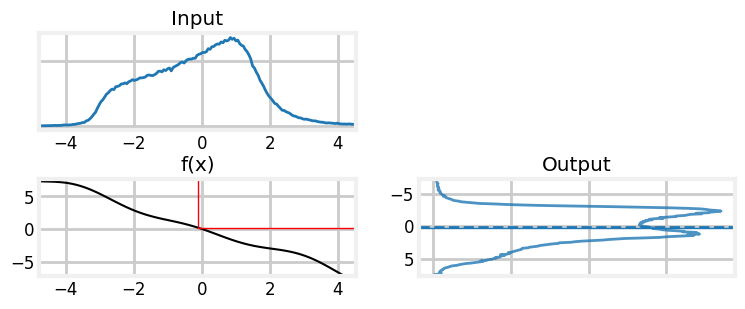

In [16]:
y = g2(data)
gaussian2 = (np.mean(y), np.var(y))

plot_nonlinear_func(y, g2, gaussian2)

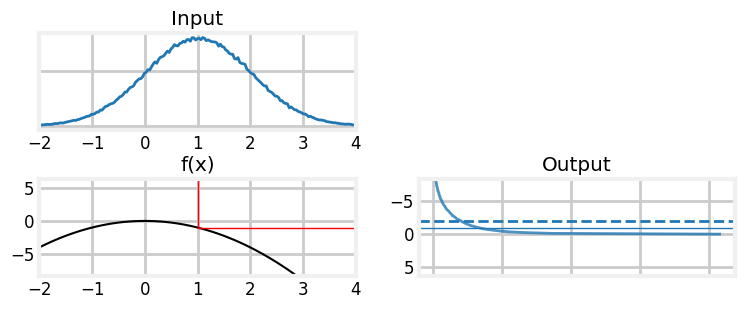

In [17]:
def g3(x): 
    return -x*x
x0 = (1, 1)
data = normal(loc=x0[0], scale=x0[1], size=500000)
plot_nonlinear_func(data, g3, gaussian=x0)

### EKF

 I put boxes around the differences from the linear filter:

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

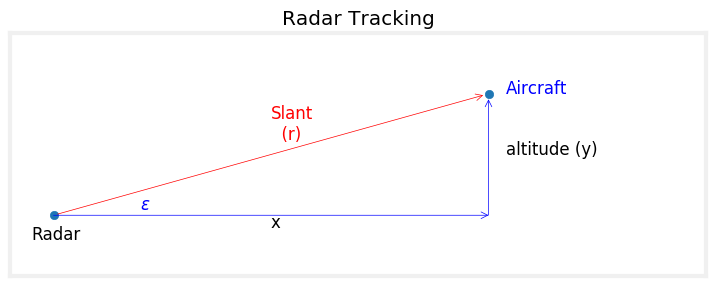

In [19]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

### Design the State Variables

We want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. That means we need 3 state variables - horizontal distance, horizonal velocity, and altitude:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

### Design the Measurement Model

The measurement function takes the state estimate of the prior $\bar{\mathbf x}$ and turn it into a measurement of the slant range distance. We use the Pythagorean theorem to derive:

$$h(\bar{\mathbf x}) = \sqrt{x^2 + y^2}$$

The relationship between the slant distance and the position on the ground is nonlinear due to the square root. We linearize it by evaluating its partial derivative at $\mathbf x_t$:

$$
\mathbf H = \frac{\partial{h(\bar{\mathbf x})}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}
$$

The partial derivative of a matrix is called a Jacobian, and takes the form 

$$\frac{\partial \mathbf H}{\partial \bar{\mathbf x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

In other words, each element in the matrix is the partial derivative of the function $h$ with respect to the $x$ variables. For our problem we have

$$\mathbf H = \begin{bmatrix}{\partial h}/{\partial x} & {\partial h}/{\partial \dot{x}} & {\partial h}/{\partial y}\end{bmatrix}$$

Solving each in turn:

$$\begin{aligned}
\frac{\partial h}{\partial x} &= \frac{\partial}{\partial x} \sqrt{x^2 + y^2} \\
&= \frac{x}{\sqrt{x^2 + y^2}}
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial \dot{x}} &=
\frac{\partial}{\partial \dot{x}} \sqrt{x^2 + y^2} \\ 
&= 0
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial y} &= \frac{\partial}{\partial y} \sqrt{x^2 + y^2} \\ 
&= \frac{y}{\sqrt{x^2 + y^2}}
\end{aligned}$$

giving us 

$$\mathbf H = 
\begin{bmatrix}
\frac{x}{\sqrt{x^2 + y^2}} & 
0 &
&
\frac{y}{\sqrt{x^2 + y^2}}
\end{bmatrix}$$

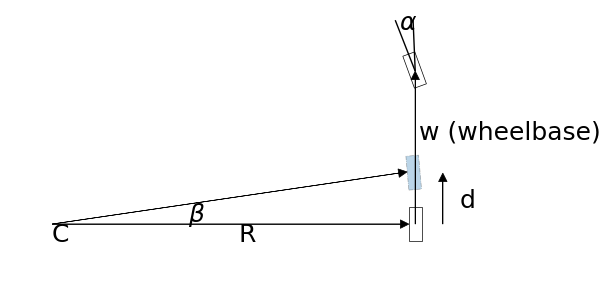

In [20]:
ekf_internal.plot_bicycle()

$$\begin{aligned} 
\beta &= \frac d w \tan(\alpha) \\
x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

where $\theta$ is the robot's heading.

You do not need to understand this model in detail if you are not interested in steering models. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.

### Design the System Model

We model our system as a nonlinear motion model plus noise.

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$



Using the motion model for a robot that we created above, we can expand this to

$$\bar{\begin{bmatrix}x\\y\\\theta\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

We find The $\mathbf F$ by taking the Jacobian of $f(x,u)$.

$$\mathbf F = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

When we calculate these we get

$$\mathbf F = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

### Unscented Kalman Filter

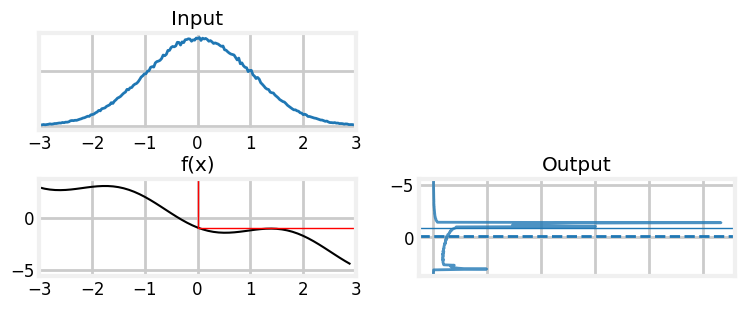

In [21]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def g(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, g, gaussian=gaussian)

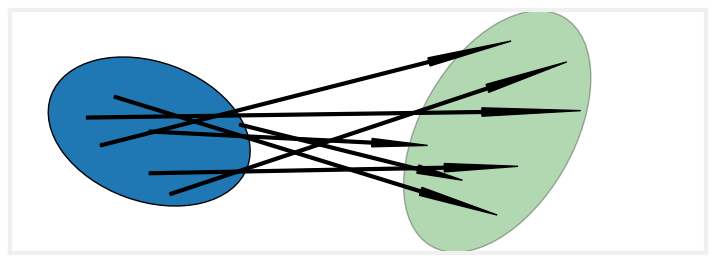

In [22]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

Difference in mean x=0.034, y=42.913


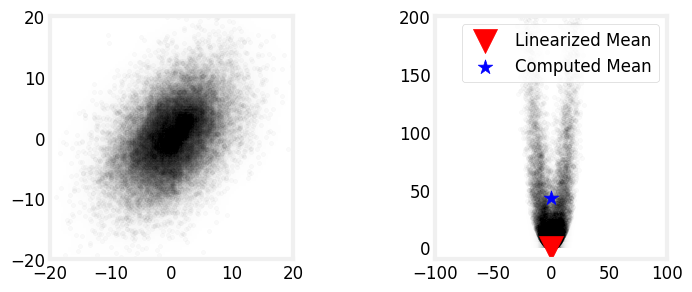

In [23]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

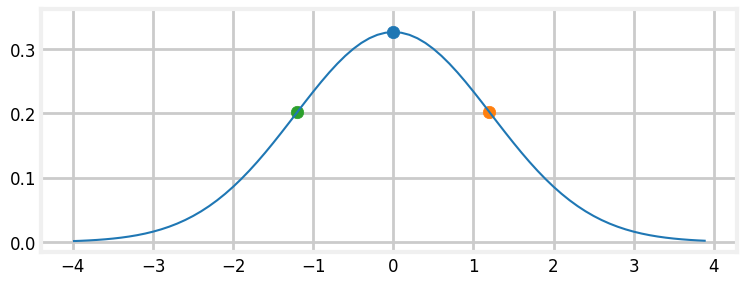

In [24]:
ukf_internal.show_3_sigma_points()

$$\begin{aligned}
\mathbf{Constraints:}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

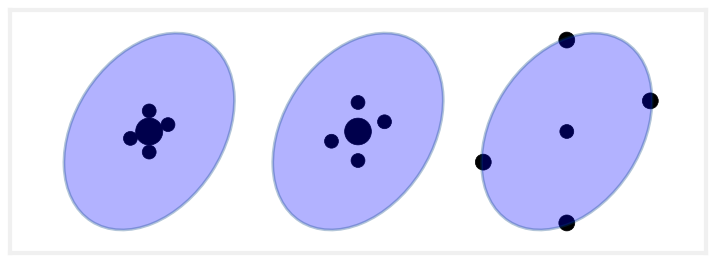

In [25]:
ukf_internal.show_sigma_selections()

## The Unscented Transform

For the moment, assume an algorithm for selecting the sigma points and weights exists. How are the sigma points used to implement a filter?

The *unscented transform* is the core of the algorithm yet it is remarkably simple. It passes the sigma points $\boldsymbol{\chi}$ through a nonlinear function yielding a transformed set of points.

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

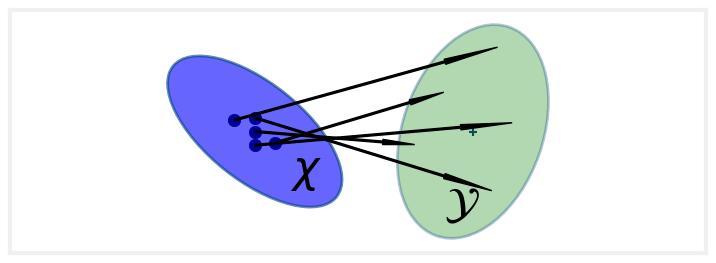

In [26]:
ukf_internal.show_sigma_transform(with_text=True)

The mean and covariance of the sigma points are computed as:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

These equations should be familar - they are the constraint equations we developed above. 

In short, the unscented transform estimates the mean and covariance of a Gaussian passed through an arbitrary, nonlinear function and produces another Gaussian from the transformed points. I hope you can envision how we can use this to implement a nonlinear Kalman filter. 

Difference in mean x=-0.097, y=0.549


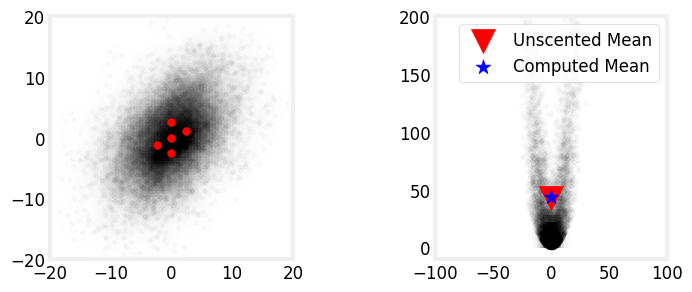

In [27]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points - we will learn about this later
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
Wm, Wc = points.weights()
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, Wm, Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

## Van der Merwe's Scaled Sigma Point Algorithm

There are many algorithms for selecting sigma points.  Since 2005 or so research and industry have mostly settled on the version published by Rudolph Van der Merwe in his 2004 PhD dissertation [1]. It performs well with a variety of problems and it has a good tradeoff between performance and accuracy. It is a slight reformulation of the *Scaled Unscented Transform* published by Simon J. Julier [2].

This formulation uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$. Before we work through the equations, let's look at an example. I will plot the sigma points on top of a covariance ellipse showing the first and second standard deviations, and scale the points based on  the mean weights.

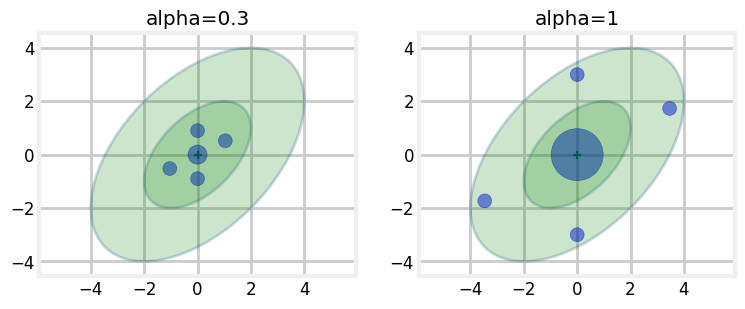

In [28]:
ukf_internal.plot_sigma_points()

## Monte Carlo Sampling

For the UKF I generated a plot similar to this to illustrate the effects of nonlinear systems on Gaussians:

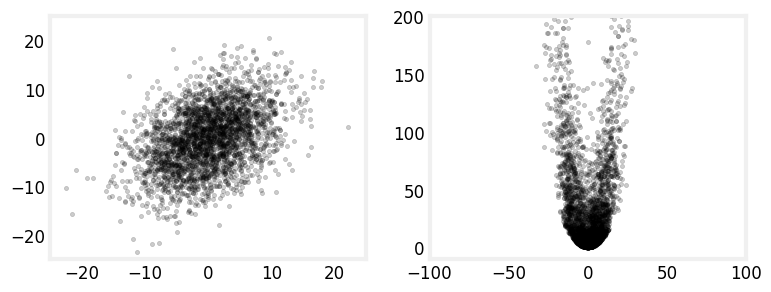

In [29]:
import kf_book.pf_internal as pf_internal
pf_internal.plot_monte_carlo_ukf()

The left plot shows 3,000 points normally distributed based on the Gaussian

$$\mu = \begin{bmatrix}0\\0\end{bmatrix},\, \, \, \Sigma = \begin{bmatrix}32&15\\15&40\end{bmatrix}$$

The right plots shows these points passed through this set of equations:

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

Using a finite number of randomly sampled points to compute a result is called a [*Monte Carlo*](https://en.wikipedia.org/wiki/Monte_Carlo_method) (MC) method. The idea is simple. Generate enough points to get a representative sample of the problem, run the points through the system you are modeling, and then compute the results on the transformed points. 

In a nutshell this is what particle filtering does. The Bayesian filter algorithm we have been using throughout the book is applied to thousands of particles, where each particle represents a *possible* state for the system. We extract the estimated state from the thousands of particles using weighted statistics of the particles.

## Generic Particle Filter Algorithm

1. **Randomly generate a bunch of particles**
    
  Particles can have position, heading, and/or whatever other state variable you need to estimate. Each has a weight (probability) indicating how likely it matches the actual state of the system. Initialize each with the same weight.
  
2. **Predict next state of the particles**

 Move the particles based on how you predict the real system is behaving.

3. **Update**

  Update the weighting of the particles based on the measurement. Particles that closely match the measurements are weighted higher than particles which don't match the measurements very well.
  
4. **Resample**

  Discard highly improbable particle and replace them with copies of the more probable particles.
  
5. **Compute Estimate**

  Optionally, compute weighted mean and covariance of the set of particles to get a state estimate.

This naive algorithm has practical difficulties which we will need to overcome, but this is the general idea. Let's see an example. I wrote a particle filter for the robot localization problem from the UKF and EKF chapters. The robot has steering and velocity control inputs. It has sensors that measures distance to visible landmarks. Both the sensors and control mechanism have noise in them, and we need to track the robot's position.

Here I run a particle filter and plotted the positions of the particles. The plot on the left is after one iteration, and on the right is after 10. The red 'X' shows the actual position of the robot, and the large circle is the computed weighted mean position.

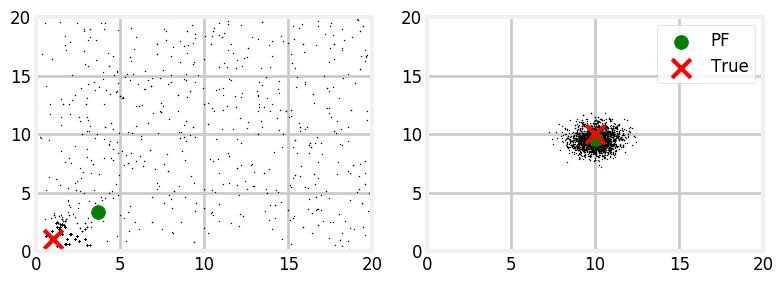

In [30]:
pf_internal.show_two_pf_plots()

<img src='animations/particle_filter_anim.gif'>

mean pi(N=20000)= 3.1684
err  pi(N=20000)= -0.0268


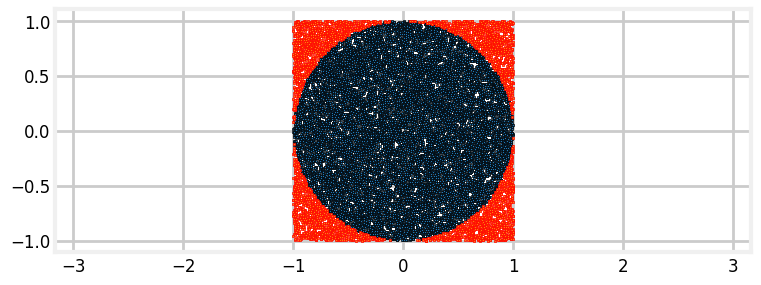

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform 

N = 20000  # number of points
radius = 1
area = (2*radius)**2

pts = uniform(-1, 1, (N, 2))

# distance from (0,0) 
dist = np.linalg.norm(pts, axis=1)
in_circle = dist <= 1

pts_in_circle = np.count_nonzero(in_circle)
pi = area * (pts_in_circle / N)

# plot results
plt.scatter(pts[in_circle,0], pts[in_circle,1], 
            marker=',', edgecolor='k', s=1)
plt.scatter(pts[~in_circle,0], pts[~in_circle,1], 
            marker=',', edgecolor='r', s=1)
plt.axis('equal')

print('mean pi(N={})= {:.4f}'.format(N, pi))
print('err  pi(N={})= {:.4f}'.format(N, np.pi-pi))

### Adaptive Filtering

In [36]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from math import sin, cos, radians

def angle_between(x, y):
  return min(y-x, y-x+360, y-x-360, key=abs)

class ManeuveringTarget(object): 
    def __init__(self, x0, y0, v0, heading):
        self.x = x0
        self.y = y0
        self.vel = v0
        self.hdg = heading
        
        self.cmd_vel = v0
        self.cmd_hdg = heading
        self.vel_step = 0
        self.hdg_step = 0
        self.vel_delta = 0
        self.hdg_delta = 0
        
        
    def update(self):
        vx = self.vel * cos(radians(90-self.hdg))
        vy = self.vel * sin(radians(90-self.hdg))
        self.x += vx
        self.y += vy
        
        if self.hdg_step > 0:
            self.hdg_step -= 1
            self.hdg += self.hdg_delta

        if self.vel_step > 0:
            self.vel_step -= 1
            self.vel += self.vel_delta
        return (self.x, self.y)
        

    def set_commanded_heading(self, hdg_degrees, steps):
        self.cmd_hdg = hdg_degrees
        self.hdg_delta = angle_between(self.cmd_hdg, 
                                       self.hdg) / steps
        if abs(self.hdg_delta) > 0:
            self.hdg_step = steps
        else:
            self.hdg_step = 0
            
            
    def set_commanded_speed(self, speed, steps):
        self.cmd_vel = speed
        self.vel_delta = (self.cmd_vel - self.vel) / steps
        if abs(self.vel_delta) > 0:
            self.vel_step = steps
        else:
            self.vel_step = 0 

def make_cv_filter(dt, std):
    cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
    cvfilter.x = np.array([0., 0.])
    cvfilter.P *= 3
    cvfilter.R *= std**2
    cvfilter.F = np.array([[1, dt],
                           [0,  1]], dtype=float)
    cvfilter.H = np.array([[1, 0]], dtype=float)
    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    return cvfilter

def initialize_filter(kf, std_R=None):
    """ helper function - we will be reinitialing the filter
    many times.
    """
    kf.x.fill(0.)
    kf.P = np.eye(kf.dim_x) * .1
    if std_R is not None:
        kf.R = np.eye(kf.dim_z) * std_R

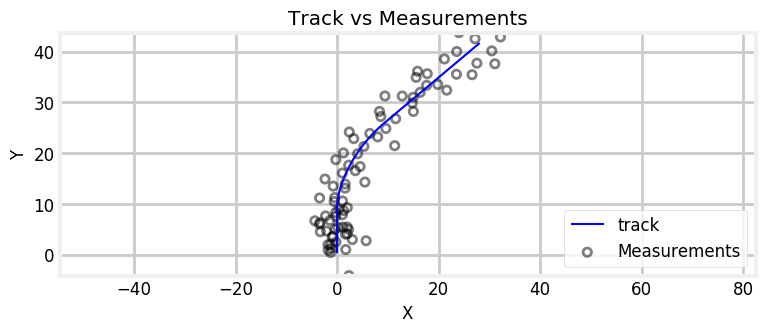

In [49]:
import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

class NoisySensor(object):
    def __init__(self, std_noise=1.):
        self.std = std_noise

    def sense(self, pos):
        """Pass in actual position as tuple (x, y).       
        Returns position with noise added (x,y)"""
        
        return (pos[0] + (randn() * self.std), 
                pos[1] + (randn() * self.std))

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

import kf_book.book_plots as bp
import numpy as np
import matplotlib.pyplot as plt

def generate_data(steady_count, std):
    t = ManeuveringTarget(x0=0, y0=0, v0=0.3, heading=0)
    xs, ys = [], []

    for i in range(30):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    t.set_commanded_heading(310, 25)
    t.set_commanded_speed(1, 15)

    for i in range(steady_count):
        x, y = t.update()
        xs.append(x)
        ys.append(y)

    ns = NoisySensor(std)
    pos = np.array(list(zip(xs, ys)))
    zs = np.array([ns.sense(p) for p in pos])
    return pos, zs

sensor_std = 2.
track, zs = generate_data(50, sensor_std)
plt.figure()
bp.plot_measurements(*zip(*zs), alpha=0.5)
plt.plot(*zip(*track), color='b', label='track')
plt.axis('equal')
plt.legend(loc=4)
bp.set_labels(title='Track vs Measurements', x='X', y='Y')

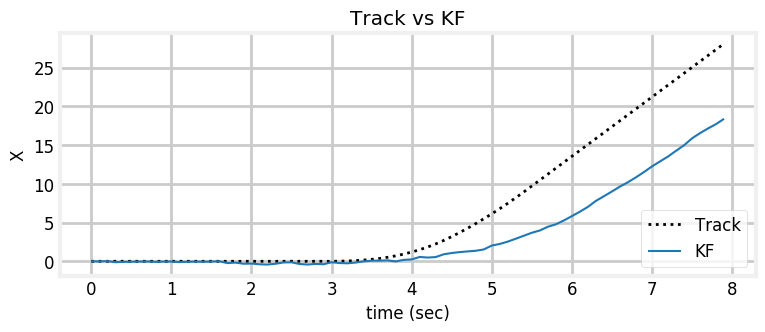

In [50]:
sensor_std = 2.
dt = 0.1

# initialize filter
cvfilter = make_cv_filter(dt, sensor_std)
initialize_filter(cvfilter)

track, zs = generate_data(50, sensor_std)

# run it
z_xs = zs[:, 0]
kxs, _, _, _ = cvfilter.batch_filter(z_xs)

# plot results
bp.plot_track(track[:, 0], dt=dt)
bp.plot_filter(kxs[:, 0], dt=dt, label='KF')
bp.set_labels(title='Track vs KF', x='time (sec)', y='X');
plt.legend(loc=4);

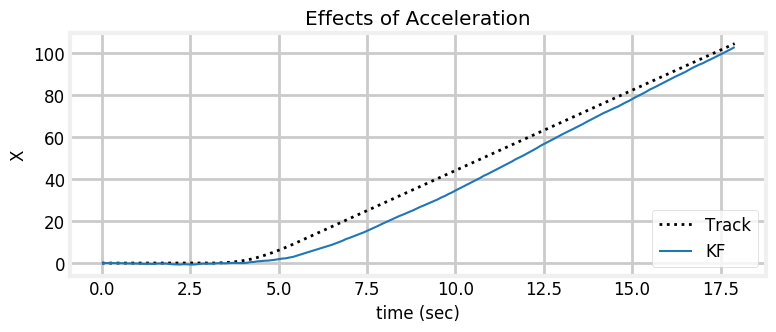

In [39]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)

track2, zs2 = generate_data(150, sensor_std)
xs2 = track2[:, 0]
z_xs2 = zs2[:, 0]

kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Effects of Acceleration', 
              x='time (sec)', y='X')

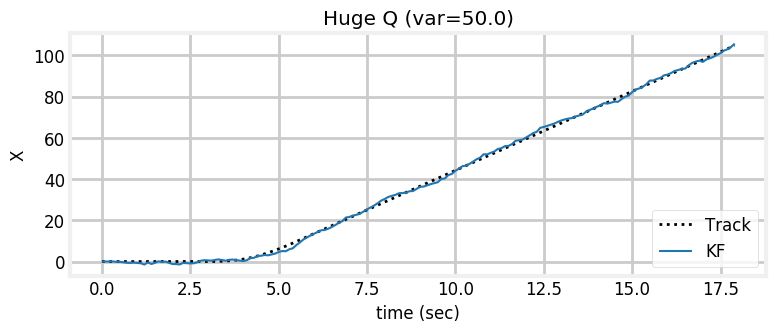

In [40]:
# reinitialize filter
dt = 0.1
initialize_filter(cvfilter)
cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=50.0)
track, zs = generate_data(50, sensor_std)

# recompute track
cvfilter.x.fill(0.)
kxs2, _, _, _ = cvfilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Huge Q (var=50.0)', x='time (sec)', y='X')

In [41]:
def make_ca_filter(dt, std):
    cafilter = KalmanFilter(dim_x=3, dim_z=1)
    cafilter.x = np.array([0., 0., 0.])
    cafilter.P *= 3
    cafilter.R *= std
    cafilter.Q = Q_discrete_white_noise(dim=3, dt=dt, var=0.02)
    cafilter.F = np.array([[1, dt, 0.5*dt*dt],
                           [0, 1,         dt], 
                           [0, 0,          1]])
    cafilter.H = np.array([[1., 0, 0]])
    return cafilter

def initialize_const_accel(f):
    f.x = np.array([0., 0., 0.])
    f.P = np.eye(3) * 3

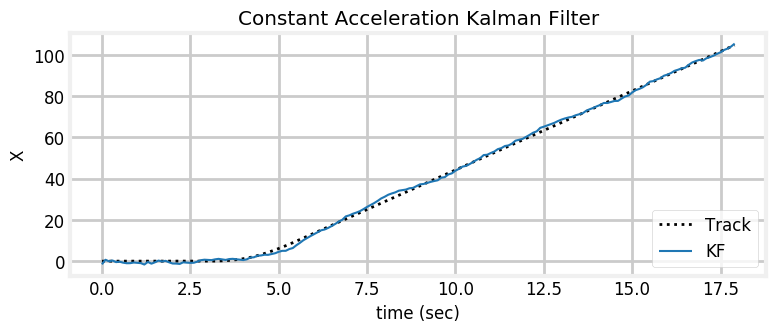

In [42]:
dt = 0.1
cafilter = make_ca_filter(dt, sensor_std)
initialize_const_accel(cafilter)

kxs2, _, _, _ = cafilter.batch_filter(z_xs2)

bp.plot_track(xs2, dt=dt)
bp.plot_filter(kxs2[:, 0], dt=dt, label='KF')
plt.legend(loc=4)
bp.set_labels(title='Constant Acceleration Kalman Filter',
              x='time (sec)', y='X')

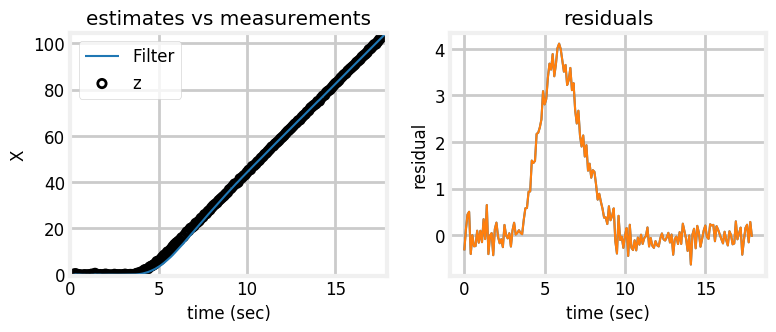

In [43]:
from kf_book.adaptive_internal import plot_track_and_residuals

def show_residual_chart():
    dt = 0.1
    sensor_std = 0.2
    
    # initialize filter
    cvfilter = make_cv_filter(dt, sensor_std)
    initialize_filter(cvfilter)
    pos2, zs2 = generate_data(150, sensor_std)
    xs2 = pos2[:, 0]
    z_xs2 = zs2[:, 0]

    cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.02)
    xs, res = [], []
    for z in z_xs2:
        cvfilter.predict()
        cvfilter.update([z])
        xs.append(cvfilter.x[0])
        res.append(cvfilter.y[0])
        
    xs = np.asarray(xs)
    plot_track_and_residuals(dt, xs, z_xs2, res)

show_residual_chart();

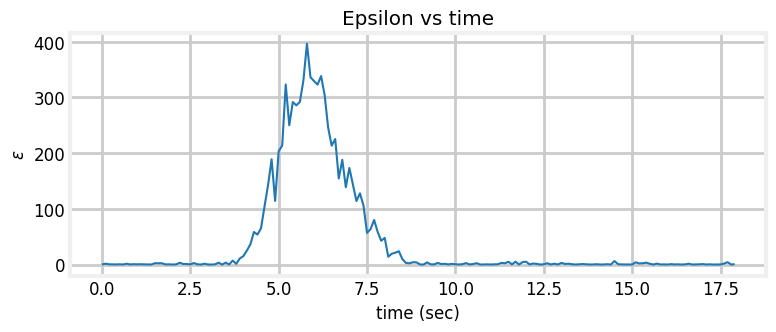

In [44]:
from numpy.linalg import inv
dt = 0.1
sensor_std = 0.2
cvfilter= make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(150, sensor_std)

epss = []
for z in zs2[:, 0]:
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)

t = np.arange(0, len(epss) * dt, dt)
plt.plot(t, epss)
bp.set_labels(title='Epsilon vs time', 
              x='time (sec)', y='$\epsilon$')

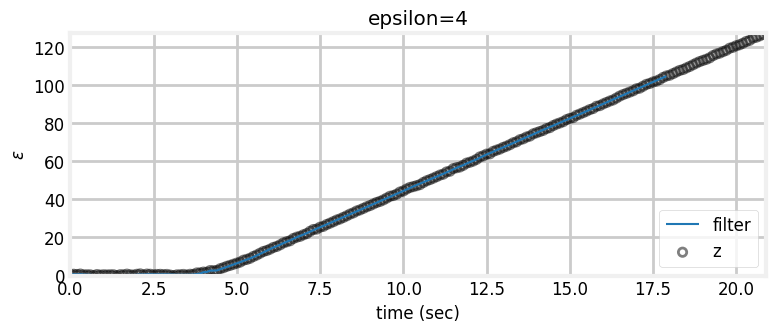

In [45]:
# reinitialize filter
dt = 0.1
sensor_std = 0.2
cvfilter = make_cv_filter(dt, sensor_std)
_, zs2 = generate_data(180, sensor_std)

Q_scale_factor = 1000.
eps_max = 4.

xs, epss = [], []

count = 0
for i, z in zip(t, zs2[:, 0]):
    cvfilter.predict()
    cvfilter.update([z])
    y, S = cvfilter.y, cvfilter.S
    eps = np.dot(y.T, inv(S)).dot(y)
    epss.append(eps)
    xs.append(cvfilter.x[0])

    if eps > eps_max:
        cvfilter.Q *= Q_scale_factor
        count += 1
    elif count > 0:
        cvfilter.Q /= Q_scale_factor
        count -= 1

bp.plot_measurements(zs2[:,0], dt=dt, label='z', alpha=0.5)
bp.plot_filter(t, xs, label='filter')
plt.legend(loc=4)
bp.set_labels(title='epsilon=4', x='time (sec)', y='$\epsilon$')

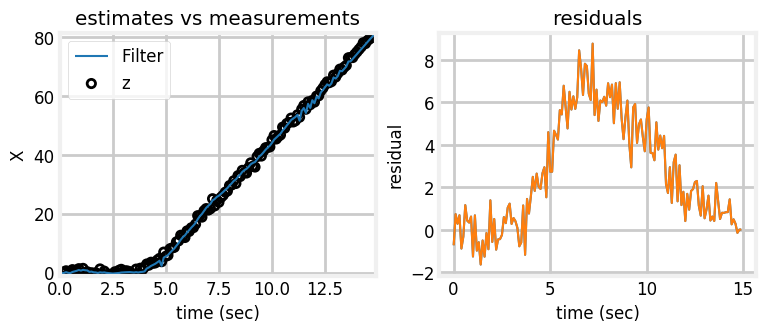

In [46]:
def run_filter_bank(threshold, show_zs=True):
    dt = 0.1
    cvfilter= make_cv_filter(dt, std=0.8)
    cafilter = make_ca_filter(dt, std=0.8)
    pos, zs = generate_data(120, std=0.8)
    z_xs = zs[:, 0]
    xs, res = [], []

    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        std = np.sqrt(cvfilter.R[0,0])
        if abs(cvfilter.y[0]) < 2 * std:
            xs.append(cvfilter.x[0])
        else:
            xs.append(cafilter.x[0])
        res.append(cvfilter.y[0])
    xs = np.asarray(xs)
    if show_zs:
        plot_track_and_residuals(dt, xs, z_xs, res)
    else:
        plot_track_and_residuals(dt, xs, None, res)

run_filter_bank(threshold=1.4)

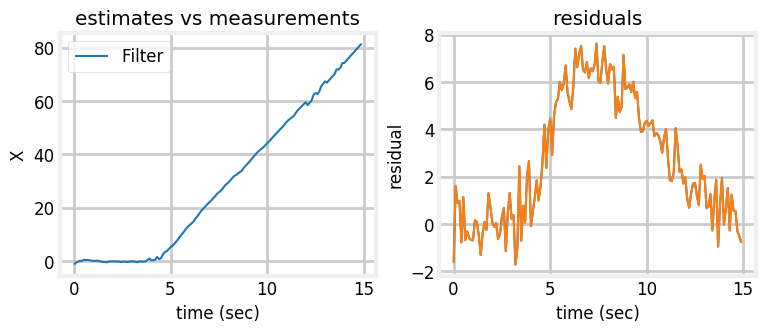

In [47]:
run_filter_bank(threshold=1.4, show_zs=False)

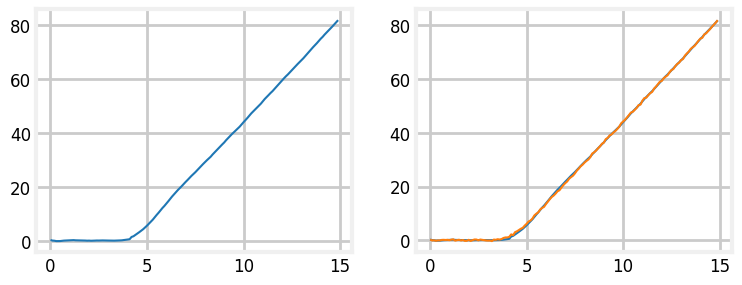

In [48]:
def run_filter_bank():
    dt = 0.1
    cvfilter = make_cv_filter(dt, std=0.2)
    cafilter = make_ca_filter(dt, std=0.2)

    _, zs = generate_data(120, std=0.2)
    z_xs = zs[:, 0]
    xs, probs = [], []

    pv, pa = 0.8, 0.2
    pvsum, pasum = 0., 0.
    
    for z in z_xs:
        cvfilter.predict()
        cafilter.predict()
        cvfilter.update([z])
        cafilter.update([z])
        
        cv_likelihood = cvfilter.likelihood([z]) * pv
        ca_likelihood = cafilter.likelihood([z]) * pa
        
        pv = (cv_likelihood) / (cv_likelihood + ca_likelihood)
        pa = (ca_likelihood) / (cv_likelihood + ca_likelihood)
        
        x = (pv * cvfilter.x[0]) + (pa*cafilter.x[0])
        xs.append(x)
        probs.append(pv / pa)

    xs = np.asarray(xs)
    t = np.arange(0, len(xs) * dt, dt)
    plt.subplot(121)
    plt.plot(t, xs)
    plt.subplot(122)
    plt.plot(t, xs)
    plt.plot(t, z_xs)
    return xs, probs

xs, probs = run_filter_bank()